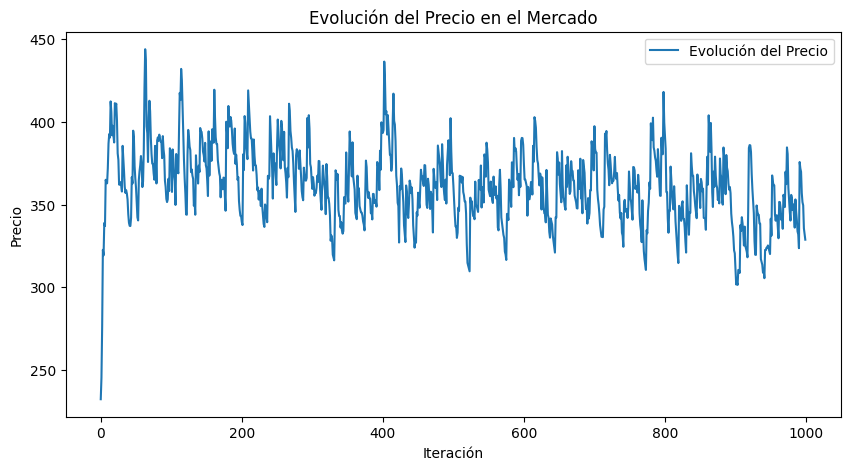

    Tipo de Agente  Balance Promedio
0  anti-tendencial        298.093917
1        aleatorio        873.401685
2       tendencial        822.346746
3           logico       2804.622840


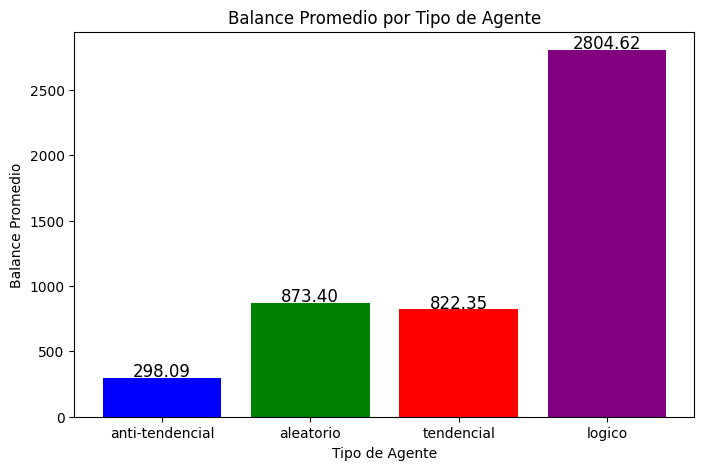

Agente 1: Tipo=anti-tendencial, Balance Final=$667.56, Tarjetas=3
Agente 2: Tipo=aleatorio, Balance Final=$230.22, Tarjetas=3
Agente 3: Tipo=tendencial, Balance Final=$922.35, Tarjetas=0
Agente 4: Tipo=tendencial, Balance Final=$1117.99, Tarjetas=0
Agente 5: Tipo=aleatorio, Balance Final=$1588.23, Tarjetas=0
Agente 6: Tipo=aleatorio, Balance Final=$1785.60, Tarjetas=0
Agente 7: Tipo=aleatorio, Balance Final=$1103.22, Tarjetas=2
Agente 8: Tipo=tendencial, Balance Final=$459.88, Tarjetas=1
Agente 9: Tipo=aleatorio, Balance Final=$560.62, Tarjetas=5
Agente 10: Tipo=tendencial, Balance Final=$463.62, Tarjetas=1
Agente 11: Tipo=aleatorio, Balance Final=$1803.79, Tarjetas=0
Agente 12: Tipo=anti-tendencial, Balance Final=$763.73, Tarjetas=2
Agente 13: Tipo=tendencial, Balance Final=$813.88, Tarjetas=1
Agente 14: Tipo=aleatorio, Balance Final=$542.99, Tarjetas=4
Agente 15: Tipo=aleatorio, Balance Final=$330.01, Tarjetas=3
Agente 16: Tipo=tendencial, Balance Final=$710.26, Tarjetas=1
Agente 17:

In [52]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from abc import ABC,abstractmethod

#Variables constantes
N_ITERACIONES=1000
N_AGENTES=100
PRECIO_INICIAL=200
STOCK_TOTAL=100000
BALANCE_INICIAL=1000
VARIACION_PRECIO=0.005  
MEDIA_CORTA=5
MEDIA_LARGA=20
RSI_PERIOD=10

class BaseAgente(ABC):
    """Clase base abstracta para los agentes"""
    
    def __init__(self,tipo):
        self.tipo=tipo
        self.balance=BALANCE_INICIAL
        self.tarjetas=0

    @abstractmethod
    def decidir_accion(self,precio,precio_anterior,historial_precios):
        """Cada agente debe definir su estrategia de compra/venta"""
        pass

class AgenteAleatorio(BaseAgente):
    def __init__(self):
        super().__init__("aleatorio")

    def decidir_accion(self,precio,precio_anterior,historial_precios):
        return random.choices(["comprar","vender","nada"], weights=[0.33,0.33,0.33],k=1)[0]

class AgenteTendencial(BaseAgente):
    def __init__(self):
        super().__init__("tendencial")

    def decidir_accion(self,precio,precio_anterior,historial_precios):
        if precio>=precio_anterior*1.01:
            return random.choices(["comprar","nada"],weights=[0.75,0.25],k=1)[0]
        return random.choices(["vender","nada"],weights=[0.2,0.8],k=1)[0]

class AgenteAntiTendencial(BaseAgente):
    def __init__(self):
        super().__init__("anti-tendencial")

    def decidir_accion(self,precio,precio_anterior,historial_precios):
        if precio<=precio_anterior*0.99:
            return random.choices(["comprar","nada"],weights=[0.75,0.25],k=1)[0]
        return random.choices(["vender","nada"],weights=[0.2,0.8],k=1)[0]
    
class AgenteLogico(BaseAgente):
    """Agente con estrategia basada en RSI (Relative Strength Index)"""
    
    def __init__(self):
        super().__init__("logico")
        self.decisiones=[]

    def calcular_rsi(self,historial_precios):
        if len(historial_precios)<RSI_PERIOD:
            return 50  #Valor neutral si no hay suficientes datos
        
        ganancias=[max(0,historial_precios[i]-historial_precios[i-1]) for i in range(1,RSI_PERIOD)]
        perdidas=[max(0,historial_precios[i-1]-historial_precios[i]) for i in range(1,RSI_PERIOD)]
        avg_ganancias=sum(ganancias)/RSI_PERIOD
        avg_perdidas=sum(perdidas)/RSI_PERIOD

        if avg_perdidas==0:
            return 100  #RSI máximo
        rs=avg_ganancias/avg_perdidas
        rsi=100-(100/(1+rs))
        return rsi

    def decidir_accion(self,precio,precio_anterior,historial_precios):
        if len(historial_precios)<RSI_PERIOD:
            self.decisiones.append(0)
            return "nada"
        
        rsi=self.calcular_rsi(historial_precios[-RSI_PERIOD:])
        
        if rsi<30 and self.balance>=precio:
            self.decisiones.append(1)
            return "comprar"
        elif rsi>70 and self.tarjetas>0:
            self.decisiones.append(-1)
            return "vender"
        self.decisiones.append(0)
        return "nada"


class Mercado:
    """Clase que representa el mercado y la simulación de agentes"""
    
    def __init__(self):
        self.precio=PRECIO_INICIAL
        self.stock=STOCK_TOTAL
        self.agentes=self.inicializar_agentes()
        self.evolucion_precio=[]

    def inicializar_agentes(self):
        """Crea y devuelve la lista de agentes en el mercado"""
        agentes=[]
        agentes+=[AgenteAleatorio() for _ in range(51)]
        agentes+=[AgenteTendencial() for _ in range(24)]
        agentes+=[AgenteAntiTendencial() for _ in range(24)]
        agentes.append(AgenteLogico())
        return agentes

    def ejecutar_iteracion(self):
        """Ejecuta una iteración del mercado, donde los agentes deciden sus acciones"""
        random.shuffle(self.agentes)
        precio_anterior=self.precio

        for agente in self.agentes:
            accion=agente.decidir_accion(self.precio, precio_anterior, self.evolucion_precio)
            if accion=="comprar" and agente.balance>=self.precio and self.stock>0:
                agente.balance-=self.precio
                agente.tarjetas+=1
                self.stock-=1
                self.precio*=(1+VARIACION_PRECIO)
            elif accion=="vender" and agente.tarjetas>0:
                agente.balance+=self.precio
                agente.tarjetas-=1
                self.stock+=1
                self.precio*=(1-VARIACION_PRECIO)

        self.evolucion_precio.append(self.precio)

    def ejecutar_simulacion(self):
        """Ejecuta la simulación del mercado con todas sus iteraciones"""
        for _ in range(N_ITERACIONES):
            self.ejecutar_iteracion()

    def mostrar_resultados(self):
        """Genera gráficos y muestra balances"""
        plt.figure(figsize=(10,5))
        plt.plot(range(N_ITERACIONES), self.evolucion_precio, label='Evolución del Precio')
        plt.xlabel("Iteración")
        plt.ylabel("Precio")
        plt.title("Evolución del Precio en el Mercado")
        plt.legend()
        plt.show()

        balances={}
        for agente in self.agentes:
            if agente.tipo not in balances:
                balances[agente.tipo]=[]
            balances[agente.tipo].append(agente.balance)
        
        promedio_balances={tipo:sum(balances[tipo])/len(balances[tipo]) for tipo in balances}
        df_balances=pd.DataFrame(list(promedio_balances.items()),columns=["Tipo de Agente","Balance Promedio"])
        print(df_balances)
        
        plt.figure(figsize=(8,5))
        bars=plt.bar(df_balances["Tipo de Agente"],df_balances["Balance Promedio"],color=['blue','green','red','purple'])
        plt.xlabel("Tipo de Agente")
        plt.ylabel("Balance Promedio")
        plt.title("Balance Promedio por Tipo de Agente")
        
        for bar in bars:
            yval=bar.get_height()
            plt.text(bar.get_x()+bar.get_width()/2,yval+10,f"{yval:.2f}",ha='center',fontsize=12)
        
        plt.show()

        for i,agente in enumerate(self.agentes):
            print(f"Agente {i+1}: Tipo={agente.tipo}, Balance Final=${agente.balance:.2f}, Tarjetas={agente.tarjetas}")



# Ejecutar la simulación
mercado=Mercado()
mercado.ejecutar_simulacion()
mercado.mostrar_resultados()
